# LangGraph 101

[LLMs](https://python.langchain.com/docs/concepts/chat_models/) make it possible to embed intelligence into a new class of applications. [LangGraph](https://langchain-ai.github.io/langgraph/) is a framework to help build applications with LLMs. Here, we will overview the basics of LangGraph, explain its benefits, show how to use it to build workflows / agents, and show how it works with [LangChain](https://www.langchain.com/) / [LangSmith](https://docs.smith.langchain.com/).


LangGraph可以快速部署基于LangChain的AI应用程序；LangSmith可以方便地对基于LangChain的应用程序进行调试、评估和监控，帮助开发者从程序原型过渡到实际生产；LaangGraph Studio则为LangGraph提供了可视化界面，开发者可以通过简单的拖曳模块构建自己的AI应用，从而进一步降低开发门槛

![ecosystem](./img/ecosystem.png)

## Chat models

[Chat models](https://python.langchain.com/docs/concepts/chat_models/) are the foundation of LLM applications. They are typically accessed through a chat interface that takes a list of [messages](https://python.langchain.com/docs/concepts/messages/) as input and returns a [message](https://python.langchain.com/docs/concepts/messages/) as output. LangChain provides [a standardized interface for chat models](https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html), making it easy to [access many different providers](https://python.langchain.com/docs/integrations/chat/).

In [5]:
from dotenv import load_dotenv
load_dotenv("../.env", override=True)

True

In [10]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    "qwen/qwen3-coder:free",
    model_provider="openai",  # OpenRouter 兼容 OpenAI 格式
    base_url="https://openrouter.ai/api/v1",
    api_key="your_openai_api",
    temperature=0
)

## Running the model

The `init_chat_model` interface provides [standardized](https://python.langchain.com/docs/concepts/runnables/) methods for using chat models, which include:
- `invoke()`: A single input is transformed into an output.
- `stream()`: Outputs are [streamed](https://python.langchain.com/docs/concepts/streaming/#stream-and-astream) as they are produced. 

In [11]:
result = llm.invoke("What is an agent?")

In [12]:
type(result)

langchain_core.messages.ai.AIMessage

In [14]:
from rich.markdown import Markdown
Markdown(result.content)

An agent can refer to several different concepts depending on the context:                                         


                                                General Definition                                                 

An agent is typically an entity that acts on behalf of another, with some degree of autonomy to make decisions and 
take actions to achieve specific goals.                                                                            


                                              Common Types of Agents:                                              

1. AI Agents                                                                                                       

 • Software programs that perceive their environment and take actions to achieve goals                             
 • Examples: chatbots, recommendation systems, autonomous vehicles                                                 

2. Human Agents                                                                                                    

 • People who act on behalf of others (agents, representatives)                                                    
 • Examples: real estate agents, travel agents, sales agents                                                       

3. Economic/Market Agents                                                                                          

 • Entities that make decisions in economic systems                                                                
 • Examples: consumers, businesses, governments                                                                    

4. Biological Agents                                                                                               

 • Organisms that can cause disease                                                                                
 • Examples: bacteria, viruses, parasites                                                                          

5. Chemical/Physical Agents                                                                                        

 • Substances that produce specific effects                                                                        
 • Examples: cleaning agents, bleaching agents                                                                     


                                                Key Characteristics                                                

Most agents share these traits:                                                                                    

 • Autonomy: Ability to operate independently                                                                      
 • Goal-directed: Work toward specific objectives                                                                  
 • Reactive: Respond to their environment                                                                          
 • Proactive: Take initiative when appropriate                                                                     

What specific type of agent were you interested in learning about?

## Tools

[Tools](https://python.langchain.com/docs/concepts/tools/) are utilities that can be called by a chat model. In LangChain, creating tools can be done using the `@tool` decorator, which transforms Python functions into callable tools. It will automatically infer the tool's name, description, and expected arguments from the function definition. You can also use [Model Context Protocol (MCP) servers](https://github.com/langchain-ai/langchain-mcp-adapters) as LangChain-compatible tools. 

@tool 装饰器把普通函数包装成 LangChain 工具，让大模型能“认识”它。

In [15]:
from langchain.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

函数签名告诉模型：发邮件需要 to, subject, content 三个参数。

In [16]:
type(write_email)

langchain_core.tools.structured.StructuredTool

In [17]:
write_email.args

{'to': {'title': 'To', 'type': 'string'},
 'subject': {'title': 'Subject', 'type': 'string'},
 'content': {'title': 'Content', 'type': 'string'}}

In [18]:
Markdown(write_email.description)

Write and send an email.

## Tool Calling

Tools can be [called](https://python.langchain.com/docs/concepts/tool_calling/) by LLMs. When a tool is bound to the model, the model can choose to call the tool by returning a structured output with tool arguments. We use the `bind_tools` method to augment an LLM with tools.

![tool-img](img/tool_call_detail.png)

Providers often have [parameters such as `tool_choice`](https://python.langchain.com/docs/how_to/tool_choice/) to enforce calling specific tools. `any` will select at least one of the tools.

In addition, we can [set `parallel_tool_calls=False`](https://python.langchain.com/docs/how_to/tool_calling_parallel/) to ensure the model will only call one tool at a time.

bind_tools 把 write_email 注册给模型，让模型在需要时可以调用。
tool_choice="any"：模型可以选任意工具（这里只有一个）。
parallel_tool_calls=False：一次只调用一个工具，避免同时发多封邮件。

用户让模型“给老板回邮件”。
模型分析后，决定调用 write_email，并自动生成参数。

In [19]:
# Connect tools to a chat model
model_with_tools = llm.bind_tools([write_email], tool_choice="any", parallel_tool_calls=False)

# The model will now be able to call tools
output = model_with_tools.invoke("Draft a response to my boss (boss@company.ai) about tomorrow's meeting")

In [20]:
type(output)

langchain_core.messages.ai.AIMessage

In [21]:
output

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4dcc057e0013455dad7a722b', 'function': {'arguments': '{"to": "boss@company.ai", "subject": "Re: Tomorrow\'s Meeting", "content": "Hi [Boss\'s Name],\\n\\nI wanted to confirm my attendance for tomorrow\'s meeting. I am looking forward to it and have prepared the necessary materials.\\n\\nPlease let me know if there\'s anything specific you\'d like me to bring or review beforehand.\\n\\nBest regards,\\n[Your Name]"}', 'name': 'write_email'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 103, 'prompt_tokens': 335, 'total_tokens': 438, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen/qwen3-coder:free', 'system_fingerprint': None, 'id': 'gen-1754983976-O1DxUWjbFMijpX5BpCk0', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c8115058-aec2-4b2c-bca5-ab9b06e9a1f7-0', tool_calls=[{'name': 'write_em

output.tool_calls[0] 取到第 1 个（也是唯一一个）工具调用对象。

['args'] 拿到它里面的参数字典

最后 write_email.invoke(args) 把参数喂给实际的工具函数，返回：
"Email sent to boss@company.ai with subject 'Re: Tomorrow's Meeting' and content: Hi Boss, …"

In [ ]:
# Extract tool calls and execute them
#把大模型决定调用工具时自动生成的参数取出来，交给真正的工具函数去执行。
args = output.tool_calls[0]['args']
args

In [23]:
# Call the tool
result = write_email.invoke(args)
Markdown(result)

Email sent to boss@company.ai with subject 'Re: Tomorrow's Meeting' and content: Hi [Boss's Name],                 

I wanted to confirm my attendance for tomorrow's meeting. I am looking forward to it and have prepared the         
necessary materials.                                                                                               

Please let me know if there's anything specific you'd like me to bring or review beforehand.                       

Best regards, [Your Name]

![basic_prompt](img/tool_call.png)

## Workflows
 
There are many patterns for building applications with LLMs. 

[We can embed LLM calls into pre-defined workflows](https://langchain-ai.github.io/langgraph/tutorials/workflows/), giving the system more agency to make decisions. 

As an example, we could add a router step to determine whether to write an email or not.

![workflow_example](img/workflow_example.png)

## Agents

We can further increase agency, allowing the LLM to dynamically direct its own tool usage. 

[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) are typically implemented as tool calling in a loop, where the output of each tool call is used to inform the next action.

![agent_example](img/agent_example.png)

Agents are well suited to open-ended problems where it's difficult to predict the *exact* steps needed in advance.
 
Workflows are often appropriate when the control flow can easily be defined in advance. 

![workflow_v_agent](img/workflow_v_agent.png)

## What is LangGraph? 

[LangGraph](https://langchain-ai.github.io/langgraph/concepts/high_level/) provides low-level supporting infrastructure that sits underneath *any* workflow or agent. 

It does not abstract prompts or architecture, and provides a few benefits:

- **Control**: Make it easy to define and / or combine agents and workflows.
- **Persistence**: Provide a way to persist the state of a graph, which enables both memory and human-in-the-loop.
- **Testing, Debugging, and Deployment**: Provide an easy onramp for testing, debugging, and deploying applications.

### Control

LangGraph lets you define your application as a graph with:

1. *State*: What information do we need to track over the course of the application?
2. *Nodes*: How do we want to update this information over the course of the application?
3. *Edges*: How do we want to connect these nodes together?

We can use the [`StateGraph` class](https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs) to initialize a LangGraph graph with a [`State` object](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

`State` defines the schema for information we want to track over the course of the application. 

This can be any object with `getattr()` in python, such as a dictionary, dataclass, or Pydantic object: 

- TypeDict is fastest but doesn’t support defaults
- Dataclass is basically as fast, supports dot syntax `state.foo`, and has defaults. 
- Pydantic is slower (especially with custom validators) but gives type validation.

总而言之，LangGraph由三部分构成——图、节点、边

图——代表整个工作流的结构，管理节点、边以及状态（State）的容器。

节点-函数，这个函数是用来处理状态的，执行具体任务，如调用 LLM、处理数据、调用工具等

边-定义流程顺序，即“下一步该执行谁”。

进一步解释图的概念：

边只能告诉你“A→B”，但图要先把这条边记录下来，运行时才知道有这条边可用。

边只是静态箭头，真正在每一步结束时读取箭头、找到下一个节点、把状态递过去的，是图内部的调度器。

节点只是把新内容更新到状态；状态本身始终放在图这个“前台抽屉”里


In [25]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class StateSchema(TypedDict):
    request: str
    email: str

workflow = StateGraph(StateSchema)

Each node is simply a python function or typescript code. This gives us full control over the logic inside each node.

They receive the current state, and return a dictionary to update the state.

By default, [state keys are overwritten](https://langchain-ai.github.io/langgraph/how-tos/state-reducers/). 

However, you can [define custom update logic](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). 

![nodes_edges](img/nodes_edges.png)

In [26]:
 #加节点（用函数处理状态）
def write_email_node(state: StateSchema) -> StateSchema:
    # Imperative code that processes the request
    output = model_with_tools.invoke(state["request"])
    args = output.tool_calls[0]['args']
    email = write_email.invoke(args)
    return {"email": email}


Edges connect nodes together. 

We specify the control flow by adding edges and nodes to our state graph. 

In [ ]:
#加边（定义流程顺序）
workflow.add_node("write_email_node", write_email_node)
workflow.add_edge(START, "write_email_node")
workflow.add_edge("write_email_node", END)

app = workflow.compile()

In [29]:
app.invoke({"request": "Draft a response to my boss (boss@company.ai) about tomorrow's meeting"})

{'request': "Draft a response to my boss (boss@company.ai) about tomorrow's meeting",
 'email': "Email sent to boss@company.ai with subject 'Tomorrow's Meeting' and content: Hi Boss,\\n\\nI wanted to confirm my attendance for tomorrow's meeting. I am looking forward to it and have prepared the necessary materials.\\n\\nBest regards,\\n[Your Name]"}

Routing between nodes can be done [conditionally](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) using a simple function. 

The return value of this function is used as the name of the node (or list of nodes) to send the state to next. 

You can optionally provide a dictionary that maps the `should_continue` output to the name of the next node.

In [32]:
from typing import Literal
from langgraph.graph import MessagesState
from email_assistant.utils import show_graph

def call_llm(state: MessagesState) -> MessagesState:
    """Run LLM"""
#让 LLM 根据对话历史决定是否需要调用 write_email 工具，并把模型返回的 AIMessage（含 tool_calls）追加到消息列表。
    output = model_with_tools.invoke(state["messages"])
    return {"messages": [output]}
#state["messages"] 是一个列表，里面按顺序保存了用户消息、AI 消息、工具返回等所有对话记录。

#model_with_tools.invoke(...) 会：1、读取对话历史
#2、如果模型觉得需要发邮件，就在返回的 AIMessage 里带上 tool_calls（包含函数名和参数）
#3、如果不需要调用工具，就返回普通文本回复

#return {"messages": [output]} 会把这条新消息追加到 state["messages"] 后面


def run_tool(state: MessagesState):
    """Performs the tool call"""
#把每个工具调用真正执行一遍，并把执行结果（role=tool）追加回消息列表。
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        observation = write_email.invoke(tool_call["args"])
        result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
    return {"messages": result}

def should_continue(state: MessagesState) -> Literal["run_tool", "__end__"]:
    """Route to tool handler, or end if Done tool called"""
#查看最新消息里有没有 tool_calls    
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]
    
    # If the last message is a tool call, check if it's a Done tool call
    if last_message.tool_calls:
        return "run_tool"
    # Otherwise, we stop (reply to the user)
    return END

workflow = StateGraph(MessagesState)
workflow.add_node("call_llm", call_llm)
workflow.add_node("run_tool", run_tool)
workflow.add_edge(START, "call_llm")
workflow.add_conditional_edges("call_llm", should_continue, {"run_tool": "run_tool", END: END})
workflow.add_edge("run_tool", END)

# Run the workflow
app = workflow.compile()

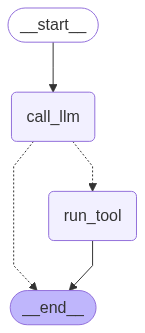

In [33]:
show_graph(app)

In [34]:
result = app.invoke({"messages": [{"role": "user", "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!"}]})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (call_db5fb9cc2794468a99967881)
 Call ID: call_db5fb9cc2794468a99967881
  Args:
    to: boss@company.ai
    subject: Confirmation of Attendance at Interrupt!
    content: Hi Boss,\n\nI wanted to confirm that I would like to attend Interrupt! Please let me know if there's anything else I need to do to finalize my registration.\n\nBest regards,\n[Your Name]
================================= Tool Message =================================

Email sent to boss@company.ai with subject 'Confirmation of Attendance at Interrupt!' and content: Hi Boss,\n\nI wanted to confirm that I would like to attend Interrupt! Please let me know if there's anything else I need to do to finalize my registration.\n\nBest regards,\n[Your N

With these low level components, you can build many many different workflows and agents. See [this tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/)!

Because agents are such a common pattern, [LangGraph](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built) has [a pre-built agent](https://langchain-ai.github.io/langgraph/agents/overview/?ref=blog.langchain.dev#what-is-an-agent) abstraction.

With LangGraph's [pre-built method](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built), we just pass in the LLM, tools, and prompt. 

create_react_agent自动帮你：

构造思考 (call_llm)

若需要发邮件，则调用 工具 (should_continue、run_tool)

把工具返回的 结果 再抛给 LLM 继续思考或给出最终回答

你无需手动写 call_llm / run_tool / should_continue 这些节点和边。

你只需要：提供{"messages": [...]} 就够了

In [35]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided."  
)

# Run the agent
result = agent.invoke(
    {"messages": [{"role": "user", "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!"}]}
)

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (call_592b3731e73c4b06930118b6)
 Call ID: call_592b3731e73c4b06930118b6
  Args:
    to: boss@company.ai
    subject: Confirmation of Attendance at Interrupt!
    content: Hi Boss,\n\nI wanted to confirm that I would like to attend Interrupt! Please let me know if there's anything else I need to do to finalize my registration.\n\nBest regards,\n[Your Name]
================================= Tool Message =================================
Name: write_email

Email sent to boss@company.ai with subject 'Confirmation of Attendance at Interrupt!' and content: Hi Boss,\n\nI wanted to confirm that I would like to attend Interrupt! Please let me know if there's anything else I need to do to finalize my registration.\n\nBest

### Persistence

#### Threads

It can be very useful to allow agents to pause during long running tasks.

LangGraph has a built-in persistence layer, implemented through checkpointers, to enable this. 

When you compile graph with a checkpointer, the checkpointer saves a [checkpoint](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpoints) of the graph state at every step. 

Checkpoints are saved to a thread, which can be accessed after graph execution completes.

![checkpointer](img/checkpoints.png)

We compile the graph with a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries).


In [36]:
from langgraph.checkpoint.memory import InMemorySaver

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided.",
    checkpointer=InMemorySaver()
)

config = {"configurable": {"thread_id": "1"}}
result = agent.invoke({"messages": [{"role": "user", "content": "What are some good practices for writing emails?"}]}, config)
                    

先用 get_state 查看历史，再用同一线程 invoke 传入新消息，Agent 会在完整上下文中自动写邮件并给出回复。

In [37]:
# Get the latest state snapshot
config = {"configurable": {"thread_id": "1"}}
state = agent.get_state(config)
for message in state.values['messages']:
    message.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Use a Clear Subject Line**: Make sure the subject line is specific and gives the recipient an idea of what the email is about.

2. **Be Concise and Direct**: Get to the point quickly. Avoid long paragraphs and unnecessary details.

3. **Use a Professional Tone**: Be polite and respectful, even if the email is informal. Avoid using slang or overly casual language.

4. **Structure Your Email Well**:
   - Start with a greeting.
   - Follow with the main message in the body.
   - End with a clear call to action or closing remark.
   - Use a professional sign-off.

5. **Check for Errors**: Proofread your email for spelling and grammar mistakes before sending.

6. **Be Mindful of the Recipient’s Time**: If the email re

In [38]:
# Continue the conversation
result = agent.invoke({"messages": [{"role": "user", "content": "Good, let's use lesson 3 to craft a response to my boss confirming that I want to attend Interrupt"}]}, config)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Use a Clear Subject Line**: Make sure the subject line is specific and gives the recipient an idea of what the email is about.

2. **Be Concise and Direct**: Get to the point quickly. Avoid long paragraphs and unnecessary details.

3. **Use a Professional Tone**: Be polite and respectful, even if the email is informal. Avoid using slang or overly casual language.

4. **Structure Your Email Well**:
   - Start with a greeting.
   - Follow with the main message in the body.
   - End with a clear call to action or closing remark.
   - Use a professional sign-off.

5. **Check for Errors**: Proofread your email for spelling and grammar mistakes before sending.

6. **Be Mindful of the Recipient’s Time**: If the email re

In [39]:
# Continue the conversation
result = agent.invoke({"messages": [{"role": "user", "content": "I like this, let's write the email to boss@company.ai"}]}, config)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Use a Clear Subject Line**: Make sure the subject line is specific and gives the recipient an idea of what the email is about.

2. **Be Concise and Direct**: Get to the point quickly. Avoid long paragraphs and unnecessary details.

3. **Use a Professional Tone**: Be polite and respectful, even if the email is informal. Avoid using slang or overly casual language.

4. **Structure Your Email Well**:
   - Start with a greeting.
   - Follow with the main message in the body.
   - End with a clear call to action or closing remark.
   - Use a professional sign-off.

5. **Check for Errors**: Proofread your email for spelling and grammar mistakes before sending.

6. **Be Mindful of the Recipient’s Time**: If the email re

#### Interrupts

In LangGraph, we can also use [interrupts](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/) to stop graph execution at specific points.

Often this is used to collect input from a user and continue execution with collected input.

In [40]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver

class State(TypedDict):
    input: str
    user_feedback: str

def step_1(state):
    print("---Step 1---")
    pass

def human_feedback(state):
    print("---human_feedback---")
    feedback = interrupt("Please provide feedback:")
    return {"user_feedback": feedback}

def step_3(state):
    print("---Step 3---")
    pass

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = InMemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

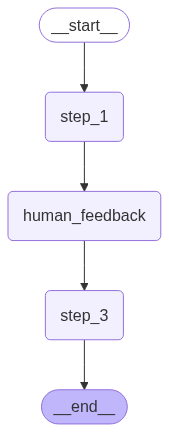

In [41]:
show_graph(graph)

In [42]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

#graph.stream(...) 把实参initial_input作为初始状态传给第一个节点step_1
# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

---Step 1---
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value='Please provide feedback:', id='15424cb31dd72e5014c282adac5ab532'),)}




To resume from an interrupt, we can use [the `Command` object](https://langchain-ai.github.io/langgraph/how-tos/command/). 

We'll use it to resume the graph from the interrupted state, passing the value to return from the interrupt call to `resume`. 

In [43]:
# Continue the graph execution
for event in graph.stream(
    Command(resume="go to step 3!"),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

---human_feedback---
{'human_feedback': {'user_feedback': 'go to step 3!'}}


---Step 3---
{'step_3': None}




### Tracing

When we are using LangChain or LangGraph, LangSmith logging [will work out of the box](https://docs.smith.langchain.com/observability/how_to_guides/trace_with_langgraph) with the following environment variables set:

```
export LANGSMITH_TRACING=true
export LANGSMITH_API_KEY="<your-langsmith-api-key>"
```

Here is the LangSmith trace from above agent execution:

https://smith.langchain.com/public/6f77014f-d054-44ed-aa2c-8b06ceab689f/r

We can see that the agent is able to continue the conversation from the previous state because we used a checkpointer.

### Deployment

We can also deploy our graph using [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/). 

This creates a server [with an API](https://langchain-ai.github.io/langgraph/cloud/reference/api/api_ref.html) that we can use to interact with our graph and an interactive IDE, LangGraph [Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/).

We simply need to ensure our project has [a structure](https://langchain-ai.github.io/langgraph/concepts/application_structure/) like this:

```
my-app/
├── src/email_assistant # all project code lies within here
│   └── langgraph101.py # code for constructing your graph
├── .env # environment variables
├── langgraph.json  # configuration file for LangGraph
└── pyproject.toml # dependencies for your project
```

The `langgraph.json` file specifies the dependencies, graphs, environment variables, and other settings required to start a LangGraph server.

To test this, let's deploy `langgraph_101.py`. We have it in our `langgraph.json` file in this repo:

```
 "langgraph101": "./src/email_assistant/langgraph_101.py:app",
```

For LangGraph Platform, there are a range of [deployment options](https://langchain-ai.github.io/langgraph/tutorials/deployment/): 
 
* Local deployments can be started with `langgraph dev` from the root directory of the repo. Checkpoints are saved to the local filesystem.
* There are also various [self-hosted options](https://langchain-ai.github.io/langgraph/tutorials/deployment/#other-deployment-options). 
* For hosted deployments, checkpoints are saved to Postgres using a postgres [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries). 

Test: 
```
Draft a response to my boss (boss@company.ai) confirming that I want to attent Interrupt!
```

Here we can see a visualization of the graph as well as the graph state in Studio.

![langgraph_studio](img/langgraph_studio.png)

Also, you can see API docs for the local deployment here:

http://127.0.0.1:2024/docs